# Example 2 - Compute Curie depth
Tanaka *et al.* (1999) based their method upon an expression for the radial power spectrum that assumes random magnetisation of the crust, and a radially averaged power spectra $\Phi_{\Delta T}(|k|)$:

$$(1) \Phi_{\Delta T}(|k|)=Ae^{-2|k|Z_t}(1-e^{-|k|(Z_b-Z_t)})^2$$

where:
 - $k$ - spatial wavenumber ($k=2\pi/\lambda$, where $\lambda$ is wavelength).
 - $Z_t$ - top of assumed magnetic source.
 - $Z_b$ - bottom of assumed magnetic source.
 - ($Z_b-Z_t$ is hence the thickness of the magnetic source)

For wavelengths less than twice the source thickness, this simplifies to:

$$(2) \ln [\Phi_{\Delta T}(|k|)^{1/2}] = \ln B-|k|Z_t $$

where $B$ is another constant. Conversely, (1) can be rewritten, with $Z_o$ as the centroid depth of the magnetic source:

$$(3) \Phi_{\Delta T}(|k|)^{1/2} = Ce^{-|k|Z_o}(e^{-|k|(Z_t-Z_o)}-e^{-|k|(Z_b-Z_o)}) $$

For long wavelengths, where $2d$ is the magnetic source thickness:
$$(4) \Phi_{\Delta T}(|k|)^{1/2} = Ce^{-|k|Z_o}(e^{-|k|(-d)}-e^{-|k|(-d)})\approx Ce^{-|k|Z_o}2|k|d $$

$$ \ln \{\Phi_{\Delta T}(|k|)^{1/2}/|k|\}=\ln D-|k|Z_o  $$


Estimates of $Z_t$ and $Z_o$ can be estimated from Equations (2) and (5), and hence the base of the magnetic source (assumed to be at the Curie point depth):

$$(6) Z_b=Z_o-(Z_t-Z_o) = 2Z_o-Z_t $$

### Contents

- [Plot radial power spectrum](#Plot-radial-power-spectrum)
- [Compute CPD Estimate](#Compute-cpd-estimate)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

In [11]:
# parameters
#(0.08,0.18), (0.01,0.033))
k_min0, k_max0 = 0.1, 0.2 # for zt
k_min1, k_max1 = 0.01, 0.033  # for zo
nx, ny = 343, 268      # nodes of grid;
window_size = 200e3    # windows size;
x_distance=15e3        # x moving distance, or x resolution
y_distance=15e3        # y moving distance, or x resolution
input_filename="../../data/out.dat"  # input data; a txt, inverse from grid;
#output_filename="../../data/zb_3var.txt"   # result data file

In [12]:
# load x,y,anomaly
mag_data = np.loadtxt(input_filename)

x = mag_data[:,0]
y = mag_data[:,1]
# sometimes you need spesify a value when the spaceing is not idnetical.
nx=len(np.unique(x))   
ny=len(np.unique(y))
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

## Plot radial power spectrum
The radial power spectrum is computed from a square window of the magnetic anomaly. Methods to select window sizes and compute the Fast Fourier Transform (FFT) belong to the `CurieGrid` object. We apply the default `np.hanning` taper to the power spectrum as in [Ex1-Plot-power-spectrum](#./Ex1-Plot-power-spectrum.ipynb).

In [13]:
# initialise CurieOptimise object
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)
#grid = pycurious.CurieGrid(d, xmin, xmax, ymin, ymax)


xc_list, yc_list = grid.create_centroid_list(window_size, spacingX=x_distance, spacingY=y_distance)


In [14]:
xcoords = np.unique(xc_list)
ycoords = np.unique(yc_list)
nc, nr = xcoords.size, ycoords.size
Z = np.zeros((nc*nr, 3))
#print(Zb.shape)
for i in range(0, len(xc_list)):
    xc=xc_list[i]
    yc=yc_list[i]
    
    subgrid = grid.subgrid(window_size, xc, yc)
    k, Phi, sigma_Phi = grid.radial_spectrum_log(subgrid, taper=None)
    # notice ,here the frequcey range is wrone , first is zt, second is zo;
    (Ztr,btr,dZtr), (Zor, bor, dZor) = grid.optimise_tanaka(k, Phi, (k_min0,k_max0), (k[1]/2/np.pi,k_max1))
    Zb=2*Zor-Ztr
    Z[i,:]=[xc, yc, Zb]
        



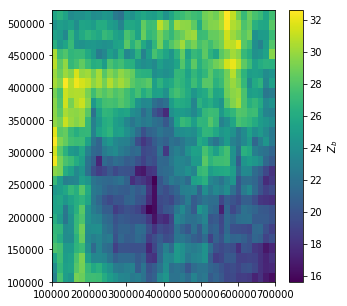

In [15]:
xcoords = np.unique(xc_list)
ycoords = np.unique(yc_list)
nc, nr = xcoords.size, ycoords.size

fig, ax1= plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,5.))
im1 = ax1.pcolor(Z[:, 0].reshape(nr,nc), Z[:, 1].reshape(nr,nc), Z[:, 2].reshape(nr,nc))
#im2 = ax2.pcolor(xc_list.reshape(nr,nc), yc_list.reshape(nr,nc), eZb.reshape(nr,nc))
fig.colorbar(im1, ax=ax1, label=r"$Z_b$")
#fig.colorbar(im2, ax=ax2, label=r"$error(z_b)$")

In [16]:

output_filename='../../data/out_200km_result.txt'
np.savetxt(output_filename, Z, fmt="%f")